In [1]:
import pandas as pd

from matplotlib import pyplot as plt
import seaborn as sns

METRICS = ['accuracy', 'precision', 'recall', 'f1']

In [2]:
df = []

for i in range(2, 6):
    d = pd.read_csv(f'../../out/csv/t5_metrics_{i}.csv')
    d['n'] = i
    df.append(d)

df = pd.concat(df)
df.rename(columns={'week': 'ds'}, inplace=True)
df['ds'] = pd.to_datetime(df['ds']).dt.date
df = df[df['ds'] >= pd.to_datetime('2023-05-07').date()]
df

,accuracy,precision,recall,f1,ds,n
1,0.464286,0.487603,0.819444,0.611399,2023-05-07,2
2,0.623288,0.555556,0.634921,0.592593,2023-05-14,2
3,0.553030,0.635135,0.594937,0.614379,2023-05-21,2
4,0.681818,0.727273,0.727273,0.727273,2023-05-28,2
5,0.753788,0.757143,0.773723,0.765343,2023-06-04,2
...,...,...,...,...,...,...
16,0.803109,0.714286,0.400000,0.512821,2023-08-20,5
17,0.814433,0.828947,0.516393,0.636364,2023-08-27,5
18,0.786082,0.884211,0.538462,0.669323,2023-09-03,5
19,0.851282,0.807407,0.773050,0.789855,2023-09-10,5


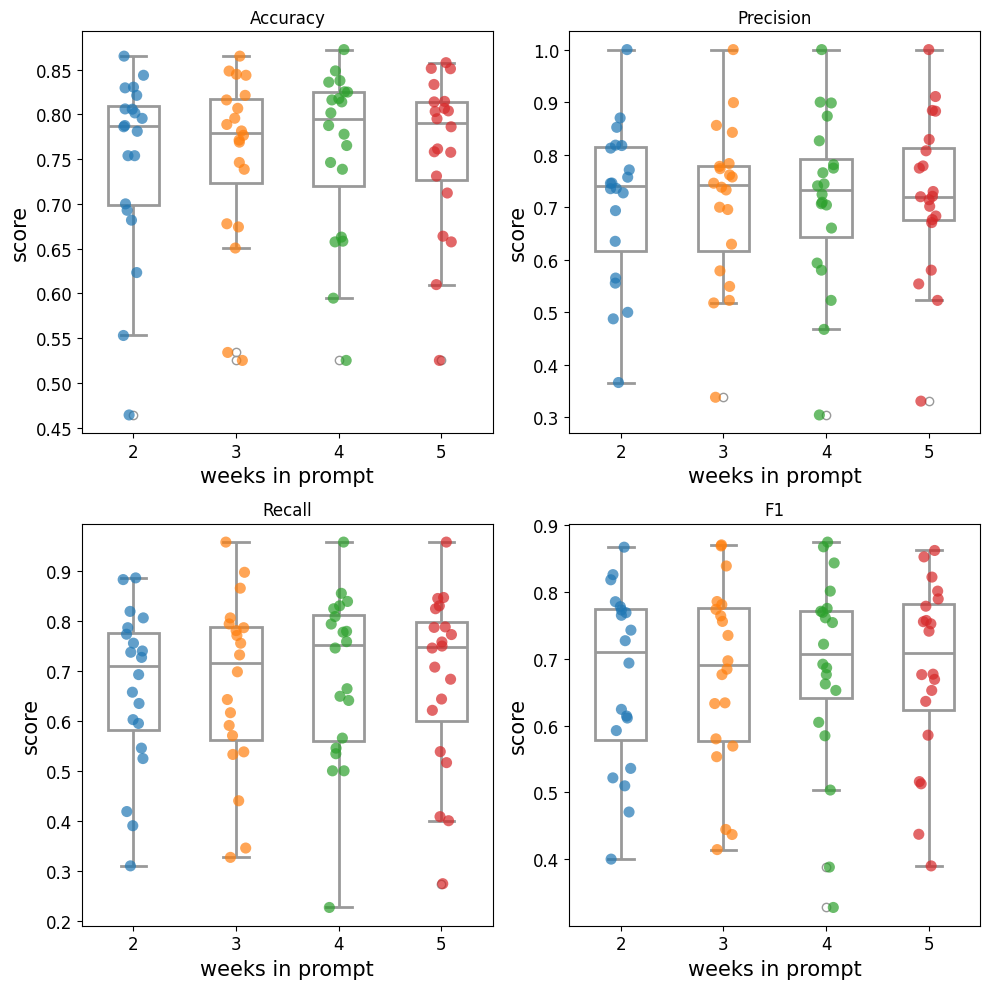

In [8]:
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

box_args = {
    'data': df,
    'x': 'n',
    'hue': 'n',
    'palette': df['n'].unique().size * ['white'],
    'linewidth': 2,
    'width': 0.5,
}

strip_args = {
    'data': df,
    'x': 'n',
    'hue': 'n',
    'size': 8,
    'palette': 'tab10'
}

for m, ax in zip(METRICS, axs.flatten()):
    sns.boxplot(**box_args, y=m, ax=ax, legend=False)
    sns.stripplot(**strip_args, y=m, ax=ax, alpha=0.7, legend=False)
    ax.set_title(m.capitalize())
    ax.set_ylabel('score', fontsize=15)
    ax.set_xlabel('weeks in prompt', fontsize=15)
    ax.tick_params(axis='x', labelsize=12)
    ax.tick_params(axis='y', labelsize=12)

fig.tight_layout()
fig.savefig('../../out/img/len_analysis.pdf')

In [4]:
describe = df.groupby('n').describe(percentiles=[.5]).T
describe.drop(index=['count', 'min', 'max'], level=1, inplace=True)

def highlight_max(s):
    d = s.sort_values(ascending=False)

    style = {
        d.index[0]: 'textbf:--rwrap ;',   # max
        d.index[1]: 'underline:--rwrap ;', # second max
        d.index[-1]: 'textit:--rwrap ;', # min
    }

    return [style.get(v, '') for v in s.index]

describe.style.apply(highlight_max, axis=1).format('{:.3f}')

describe.style.apply(highlight_max, axis=1).format('{:.3f}').format_index(escape='latex').to_latex(
        '../../out/tex/len_analysis.tex', 
        hrules=True, 
        caption='Descriptive statistics of metrics of T5-small models trained on different number of weeks. Bold indicates the highest value, underline the second highest, and italic the lowest.', 
        label='tab:len_analysis', 
        clines='skip-last;data'
    )

describe

n                      2         3         4         5
accuracy  mean  0.748785  0.753739  0.760353  0.759644
          std   0.102945  0.096567  0.093531  0.087598
          50%   0.786774  0.778994  0.794506  0.790582
precision mean  0.709585  0.710002  0.713923  0.723624
          std   0.151489  0.152184  0.162430  0.151714
          50%   0.740652  0.741929  0.732550  0.720390
recall    mean  0.664382  0.672580  0.690038  0.685134
          std   0.161834  0.175917  0.171836  0.176648
          50%   0.710042  0.715348  0.752448  0.748016
f1        mean  0.671445  0.675036  0.686112  0.683471
          std   0.134197  0.139826  0.146938  0.135785
          50%   0.710500  0.690899  0.707032  0.709306

In [5]:
ranks = describe.rank(axis=1, method='min', ascending=False)

# Fixing the ranks of the std metrics (lower is better)
ranks[ranks.index.get_level_values(1) == 'std'] = ranks[ranks.index.get_level_values(1) == 'std'].rank(axis=1, method='min', ascending=False)

ranks.mean().sort_values()

n
4    2.083333
5    2.166667
2    2.750000
3    3.000000
dtype: float64

In [6]:
# ANOVA
from scipy.stats import f_oneway
df_m = df.pivot(index='ds', columns='n')

anova_table = pd.DataFrame({m: f_oneway(*df_m[m].values.T).pvalue for m in METRICS}, index=['p-value'])
anova_table.columns = [m.capitalize() for m in METRICS]
print(anova_table.style.format('{:.3f}').to_latex(caption='ANOVA p-values for T5-small models trained on different number of weeks.', label='tab:len_anova', hrules=True))

\begin{table}
\caption{ANOVA p-values for T5-small models trained on different number of weeks.}
\label{tab:len_anova}
\begin{tabular}{lrrrr}
\toprule
 & Accuracy & Precision & Recall & F1 \\
\midrule
p-value & 0.978 & 0.991 & 0.964 & 0.985 \\
\bottomrule
\end{tabular}
\end{table}



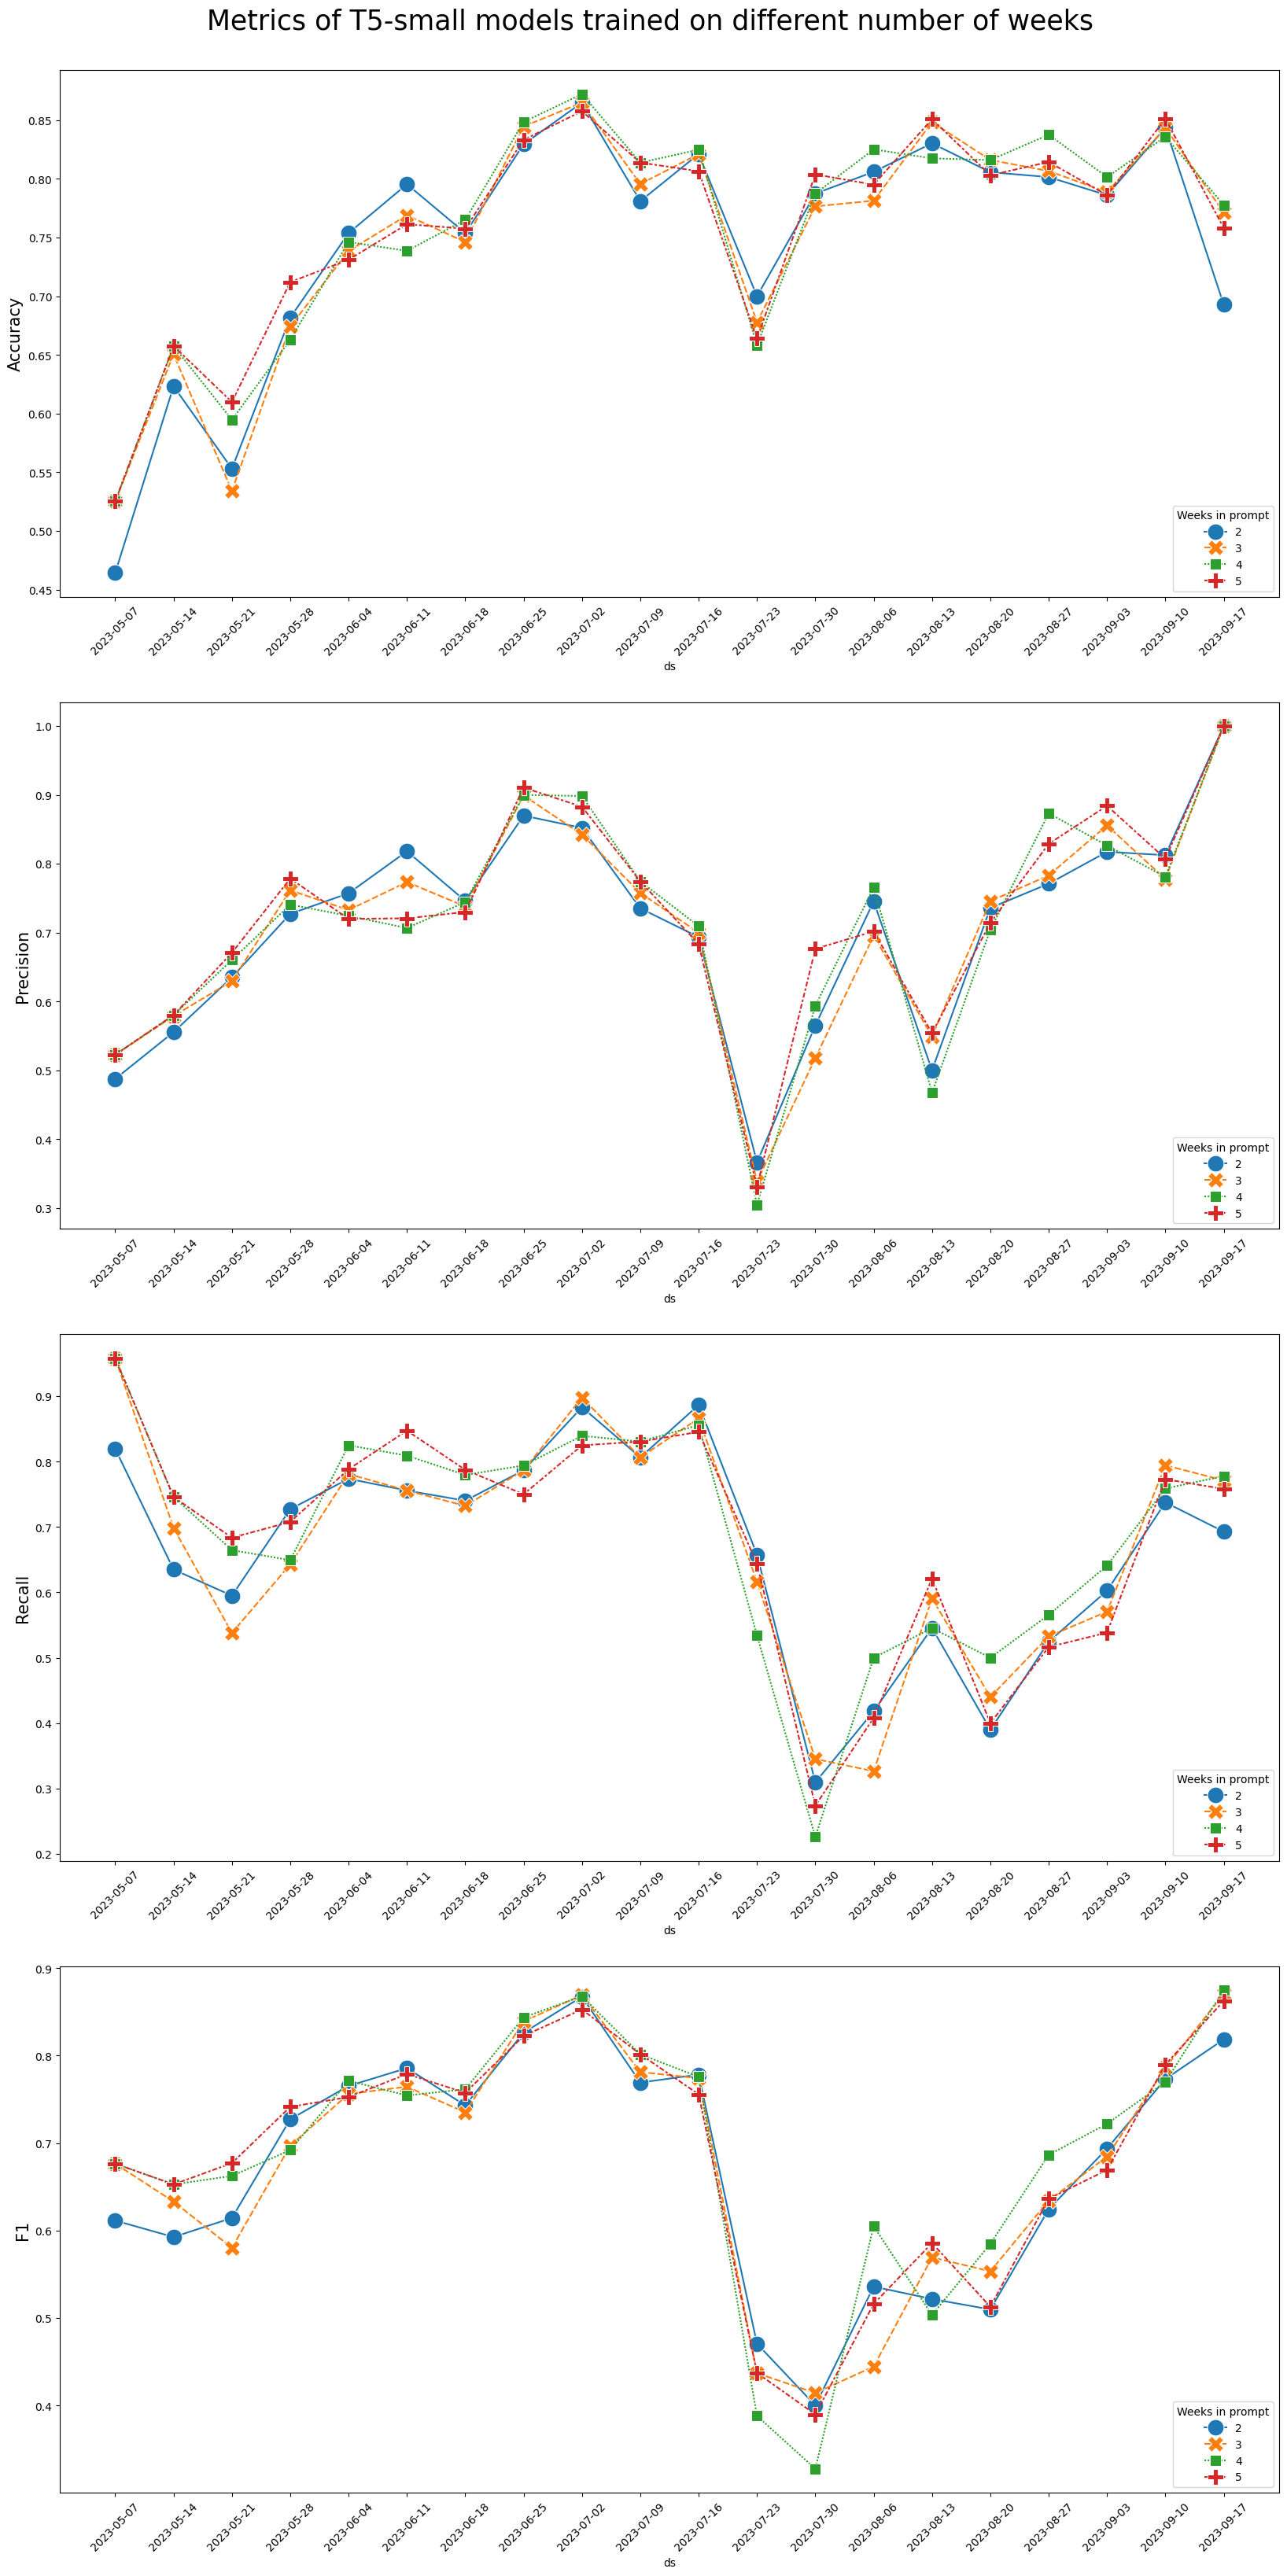

In [7]:
fig, axs = plt.subplots(4, 1, figsize=(20, 40))
fig.suptitle('Metrics of T5-small models trained on different number of weeks', fontsize=25, y=0.9)

for metric, ax in zip(['accuracy', 'precision', 'recall', 'f1'], axs.flatten()):
    sns.lineplot(data=df, x='ds', y=metric, hue='n', ax=ax, style='n', markers=True, markersize=15, linewidth=1.5, palette='tab10')
    ax.set_xticks(df['ds'].unique(), labels=df['ds'].unique(), rotation=45)
    ax.set_ylabel(metric.capitalize(), fontsize=15)
    ax.legend(title='Weeks in prompt', loc='lower right', fontsize=10)